In [24]:
pip install --upgrade numpy==1.23.5 scipy nltk googletrans==4.0.0-rc1 textblob matplotlib

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
from googletrans import Translator

In [26]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Load the dataset
df = pd.read_csv('Japan Public Sentiment 2-10-2024.csv')

In [28]:
# Preprocess the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['Post Body'].apply(preprocess_text)

# Convert 'Likes' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return float(value)

df['Likes_numeric'] = df['Likes'].apply(convert_to_numeric)


In [29]:
# Simple sentiment labeling based on median likes
median_likes = df['Likes_numeric'].median()
df['sentiment'] = df['Likes_numeric'].apply(lambda x: 1 if x > median_likes else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

# Feature extraction
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the model
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Function to predict sentiment of new text
def predict_sentiment(text):
    processed = preprocess_text(text)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)
    return "Positive" if prediction[0] == 1 else "Negative"

# Example usage
print(predict_sentiment("Renewable energy is the future of Australia"))
print(predict_sentiment("The energy policy is a complete disaster"))

              precision    recall  f1-score   support

           0       0.58      0.95      0.72        37
           1       0.75      0.19      0.31        31

    accuracy                           0.60        68
   macro avg       0.67      0.57      0.51        68
weighted avg       0.66      0.60      0.53        68

[[35  2]
 [25  6]]
Negative
Negative


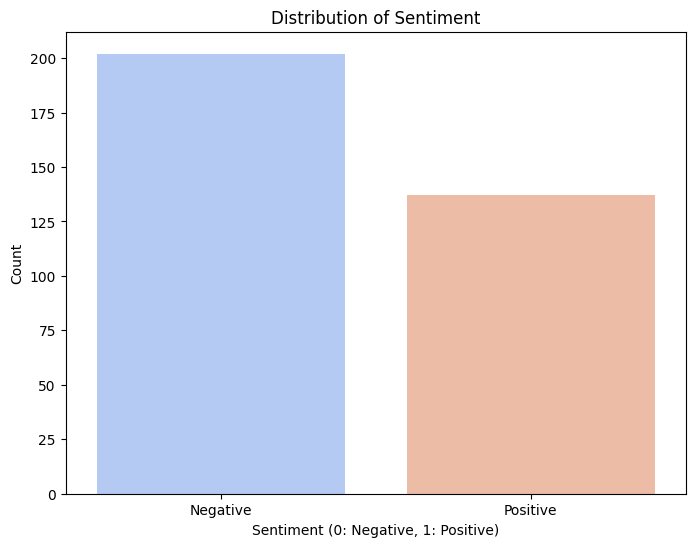

In [30]:
# Assume 'sentiment' column exists with 0 for negative and 1 for positive
# If not, ensure your data preprocessing step creates this column

# Plotting the distribution of sentiment
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [31]:
# Save results to CSV
df[['Post Body', 'sentiment']].to_csv('Japan Sentiment Result.csv', index=False)

In [32]:
import pandas as pd
from googletrans import Translator
from textblob import TextBlob


# Initialize translator
translator = Translator()

# Function to translate and analyze sentiment
def translate_and_analyze(text):
    try:
        # Translate text to English
        translated = translator.translate(text, src='jp', dest='en').text
        # Analyze sentiment
        analysis = TextBlob(translated)
        sentiment = 1 if analysis.sentiment.polarity > 0 else 0  # 1 for Positive, 0 for Negative
        return translated, sentiment
    except Exception as e:
        return '', 0  # Default to Negative if translation fails

# Apply the function to the 'Post Body' column
df[['translated_text', 'sentiment']] = df['Post Body'].apply(lambda x: pd.Series(translate_and_analyze(x)))

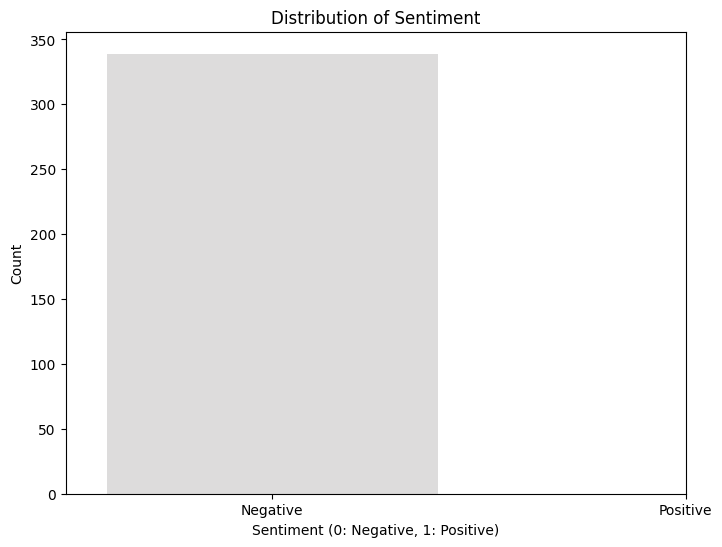

In [33]:
# Ensure 'sentiment' column exists with 0 for negative and 1 for positive
# If not, ensure your data preprocessing step creates this column

# Plotting the distribution of sentiment
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [34]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (only need to do this once)
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to convert VADER sentiment scores to a 1-5 scale
def vader_to_5scale(compound_score):
    if compound_score <= -0.75:
        return 1
    elif -0.75 < compound_score <= -0.25:
        return 2
    elif -0.25 < compound_score < 0.25:
        return 3
    elif 0.25 <= compound_score < 0.75:
        return 4
    else:
        return 5

# Perform sentiment analysis and convert to 1-5 scale
df['sentiment_score'] = df['Post Body'].apply(lambda x: vader_to_5scale(sia.polarity_scores(x)['compound']))

# Display the results
print(df[['Post Body', 'sentiment_score']])

# Save the results to a new CSV file
df.to_csv('Japan Sentiment VADER.csv', index=False)

                                             Post Body  sentiment_score
0    【#神奈川14区】中村圭ウィークリーレポートです。日々、大変な暑さです。物価上昇でエアコンを...                3
1                  日本、約1.6兆円の気候変動債の募集を開始 - ESG Journal                3
2    ドバイで開催されたCOP28（国連気候変動枠組み条約締約国会議）で、日本は世界の再生可能エネ...                3
3    「これまでに経験したことのない大雨」が頻発する日本　集中豪雨と地球温暖化の関係とは – HA...                3
4    【気候変動対策“逆行”の動き!?】\n\n日本同様、地球温暖化の影響とも思える記録的な暑さが...                3
..                                                 ...              ...
334  再生可能エネルギーの導入、なぜ日本は遅れている？専門家「技術やコストでなく…」 https:...                3
335  再生可能エネルギーの導入、なぜ日本は遅れている？専門家「技術やコストでなく…」 https:...                3
336  再生可能エネルギーの導入、なぜ日本は遅れている？専門家「技術やコストでなく…」\n\n遅れて...                3
337  やはり、再生可能エネルギーを推進していくためには、政治が動かなくては。\n\n日本の基幹産業...                3
338            再生可能エネルギーの導入、なぜ日本は遅れている？専門家「技術やコストでなく…」                3

[339 rows x 2 columns]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [37]:

# Import dataset
df = pd.read_csv('Japan Public Sentiment 2-10-2024.csv')

In [38]:

# Initialize translator
translator = Translator()

# Function to translate and clean data
def translate_and_clean(text):
    try:
        translated = translator.translate(text, src='jp', dest='en').text
        # Add any additional cleaning steps here if needed
        return translated
    except:
        return ''

# Translate and clean data
df['translated_text'] = df['Post Body'].apply(translate_and_clean)



In [39]:

# TextBlob sentiment analysis
def textblob_sentiment_category(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['textblob_sentiment_category'] = df['textblob_sentiment'].apply(textblob_sentiment_category)


KeyError: 'textblob_sentiment'

In [20]:

# BERT sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = softmax(outputs.logits.numpy(), axis=1)
    return scores.argmax() + 1

df['bert_sentiment'] = df['translated_text'].apply(bert_sentiment)


c:\Users\User\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\User\anaconda3\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`

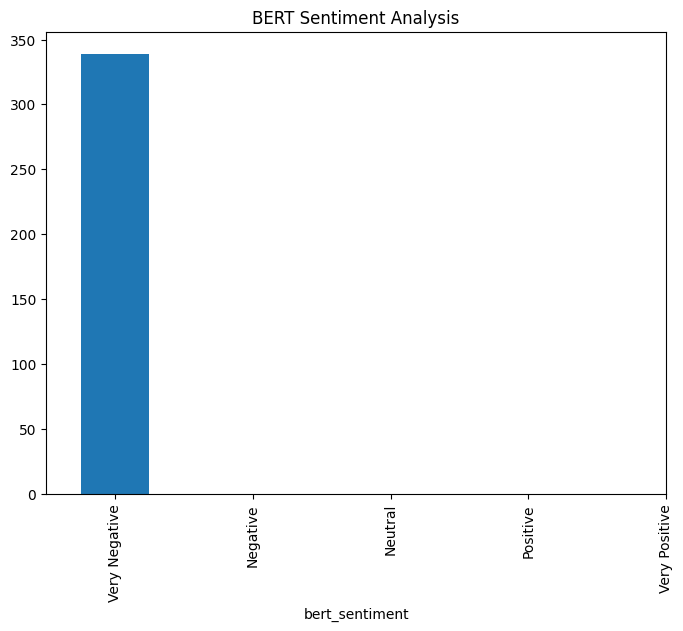

In [21]:

# Visualization for BERT sentiment analysis
plt.figure(figsize=(8, 6))
df['bert_sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('BERT Sentiment Analysis')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.show()


Agreement between TextBlob and BERT: 0.00%


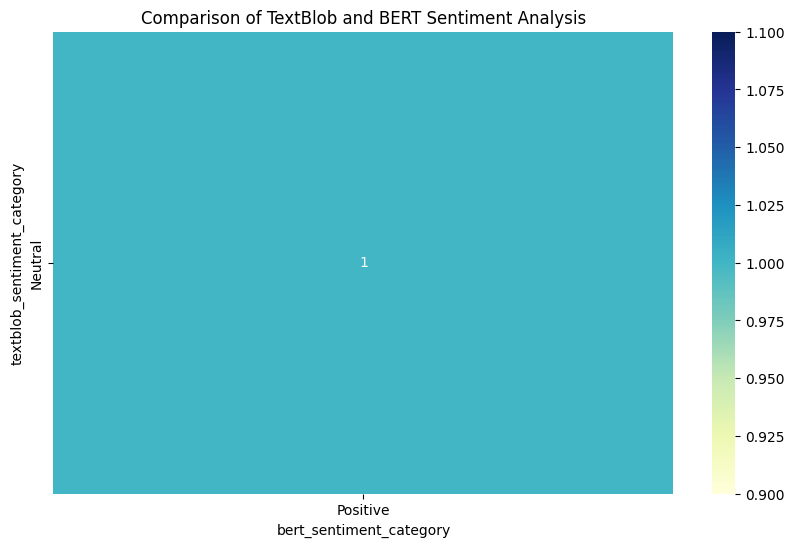

In [22]:

# Compare TextBlob and BERT results
df['bert_sentiment_category'] = df['bert_sentiment'].map({1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'})
agreement = (df['textblob_sentiment_category'] == df['bert_sentiment_category']).mean()
print(f"Agreement between TextBlob and BERT: {agreement:.2%}")

# Visualization for comparison
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['textblob_sentiment_category'], df['bert_sentiment_category'], normalize='index'), annot=True, cmap='YlGnBu')
plt.title('Comparison of TextBlob and BERT Sentiment Analysis')
plt.show()


In [23]:
# Save the results to a CSV file
df.to_csv('Japan_sentiment_analysis_results.csv', index=False)